In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as datasets

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/imagenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: imagenet-mini/train/n07875152/n07875152_2632.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_2763.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3015.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3378.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3497.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_3745.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4157.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_461.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4704.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4789.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4848.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_4940.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_546.JPEG  
  inflating: imagenet-mini/train/n07875152/n07875152_5607.JPEG  
  inflating: imagenet-mini/train/n0787515

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def load_dataset(batch_size, resize=None):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    train_dataset = datasets.ImageFolder('/content/imagenet-mini/train', transform=train_transforms)
    test_dataset =  datasets.ImageFolder('/content/imagenet-mini/val', transform=val_transforms)

    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [30000, 4745],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False,
                            num_workers=2))
    print(len(torch.utils.data.DataLoader(train_dataset)))

In [ ]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat[-1], y) #Use the main output for loss
            total_loss += float(l)
            total_hits += sum(y_hat[-1].argmax(axis=1).type(y.dtype) == y)  # Use the main output for accuracy
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat[-1], y) # use main output
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat[-1].argmax(axis=1).type(y.dtype) == y)  # Use the main output for accuracy
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.9)
    scheduler = StepLR(optimizer, step_size=8, gamma=0.96)
    # gamma (float) – Multiplicative factor of learning rate decay
    # => new learning rate=current learning rate - 0.4 => x - 0.4 = x * y => x / x = y + 0.4 => y = 0.96

    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
        scheduler.step()

    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

Inception layer sizes from the table arhitecture in paper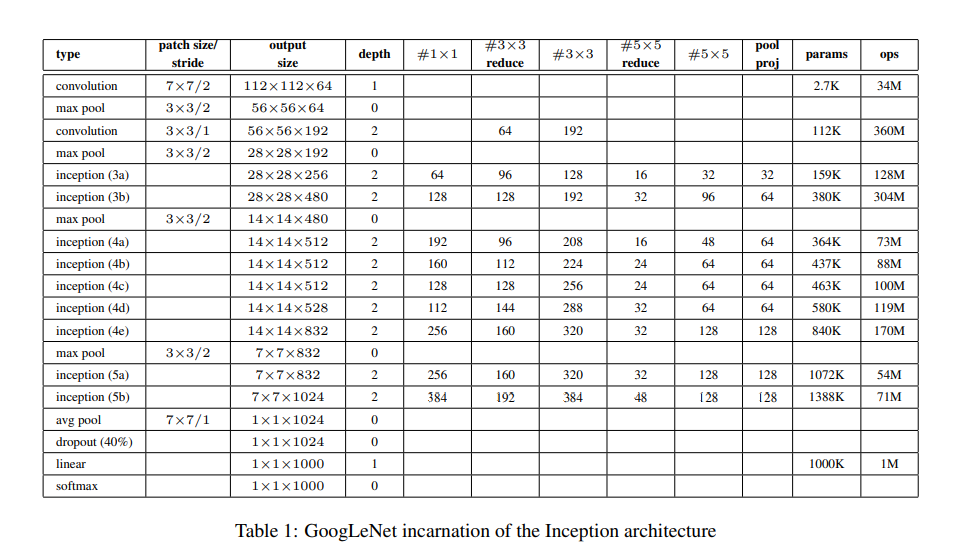

---



In [ ]:
inception_sizes=[[64, 96, 128, 16, 32, 32],
                 [128, 128, 192, 32, 96, 64],
                 [192, 96, 208, 16, 48, 64],
                 [160, 112, 224, 24, 64, 64],
                 [128, 128, 256, 24, 64, 64],
                 [112, 144, 288, 32, 64, 64],
                 [256, 160, 320, 32, 128, 128],
                 [256, 160, 320, 32, 128, 128],
                 [384, 192, 384, 48, 128, 128]]

* As we can see in the paper, the activation function used for the Inception
Module is nn.ReLU() : "All the convolutions, including those inside the Inception modules, use rectified linear activation.  All these reduction/projection layers use rectified linear activation as well."
* The size of the receptive field in our network is 224×224 taking RGB color channels (3 input_channels for start) with mean subtraction.

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, input_channels, sizeVector):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, sizeVector[0], kernel_size=1)

        self.conv2 = nn.Conv2d(input_channels, sizeVector[1], kernel_size=1)
        self.conv3 = nn.Conv2d(sizeVector[1], sizeVector[2], kernel_size=3, padding = 1)

        self.conv4 = nn.Conv2d(input_channels, sizeVector[3], kernel_size=1)
        self.conv5 = nn.Conv2d(sizeVector[3], sizeVector[4], kernel_size=5, padding = 2)

        self.maxpolling = nn.MaxPool2d(3, stride = 1, padding = 1)
        self.conv6 = nn.Conv2d(input_channels, sizeVector[5], kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y1 =  self.relu(self.conv1(X))
        Y2 = self.relu(self.conv3(self.relu(self.conv2(X))))
        Y3 = self.relu(self.conv5(self.relu(self.conv4(X))))
        Y4 = self.relu(self.conv6(self.maxpolling(X)))
        Y = torch.cat([Y1,Y2,Y3,Y4], axis = 1)
        return Y

In [ ]:
class AuxBranch(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        self.avrgpool = nn.AvgPool2d(kernel_size = 5, stride = 3)
        self.conv1 = nn.Conv2d(input_channels, 128, kernel_size=1, stride = 1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = self.relu(self.conv1(self.avrgpool(X)))
        Y  = torch.flatten(Y, start_dim=1)
        Y = self.relu(self.dropout(self.fc1(Y)))
        Y = self.fc2(Y)
        return Y

* The network is 22 layers deep when counting only layers with parameters (or 27 layers if we also count pooling). The overall number of layers (independent building blocks) used for the construction of the network is about 100.



*   We will calculate the padding of the layers using the formula :
 P = ( (Wout -1 ) x S + Fw - Win ) / 2 , where <br>
 * Input Size = Win x Hin
 * Filter Size = Fw x Fh
 * Stride = S
 * Output Size = Wout x Hout





* For example for the first layer, we look in the table and see the output size for the first conv layer is 112, and the input for GoogleLeNet has size of [ 224, 224 ]: <br>
 P = (( 112 - 1 ) x 2 + 7 - 224) / 2 => P = 3

In [ ]:
class GoogleLeNet(nn.Module):
    def __init__(self, inception_sizes, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3)
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.localresnorm = nn.LocalResponseNorm(5)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 1, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 192, kernel_size = 3, stride = 1, padding = 1)
        self.incep3a = InceptionModule(192, inception_sizes[0])
        self.incep3b = InceptionModule(256, inception_sizes[1])
        self.incep4a = InceptionModule(480, inception_sizes[2])
        self.incep4b = InceptionModule(512, inception_sizes[3])
        self.incep4c = InceptionModule(512, inception_sizes[4])
        self.incep4d = InceptionModule(512, inception_sizes[5])
        self.incep4e = InceptionModule(528, inception_sizes[6])
        self.incep5a = InceptionModule(832, inception_sizes[7])
        self.incep5b = InceptionModule(832, inception_sizes[8])
        self.aux1 = AuxBranch(512, num_classes)
        self.aux2 = AuxBranch(528, num_classes)
        self.avrpool = nn.AvgPool2d(7, stride = 1)
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()


    def forward(self, X):
        outputs = []
        Y = self.relu(self.conv1(X))
        Y = self.localresnorm(self.maxpool(Y))
        Y = self.relu(self.conv3(self.relu(self.conv2(Y))))
        Y = self.maxpool(self.localresnorm(Y))

        Y = self.incep3a(Y)
        Y = self.incep3b(Y)
        Y = self.maxpool(Y)
        Y = self.incep4a(Y)
        outputs.append(self.aux1(Y))
        Y = self.incep4b(Y)
        Y = self.incep4c(Y)
        Y = self.incep4d(Y)
        outputs.append(self.aux2(Y))
        Y = self.incep4e(Y)
        Y = self.maxpool(Y)
        Y = self.incep5a(Y)
        Y = self.incep5b(Y)

        Y = self.avrpool(Y)
        Y = self.dropout(Y)
        Y = torch.flatten(Y, start_dim=1)
        Y = self.fc(Y)
        outputs.append(Y)

        return outputs

In [ ]:
#check the ouput sizes(we got 3 outputs for the 2 auxiliar branches + final output)
model = GoogleLeNet(inception_sizes, 1000)
X = torch.rand(16, 3, 224, 224)
outputs = model(X)
for out in outputs:
  print (out.shape)

torch.Size([16, 1000])
torch.Size([16, 1000])
torch.Size([16, 1000])


In [ ]:
! pip install -q torchview
! pip install -q -U graphviz
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')
model_graph1 = draw_graph( GoogleLeNet(inception_sizes, 1000), input_size=(1, 3, 224, 224))

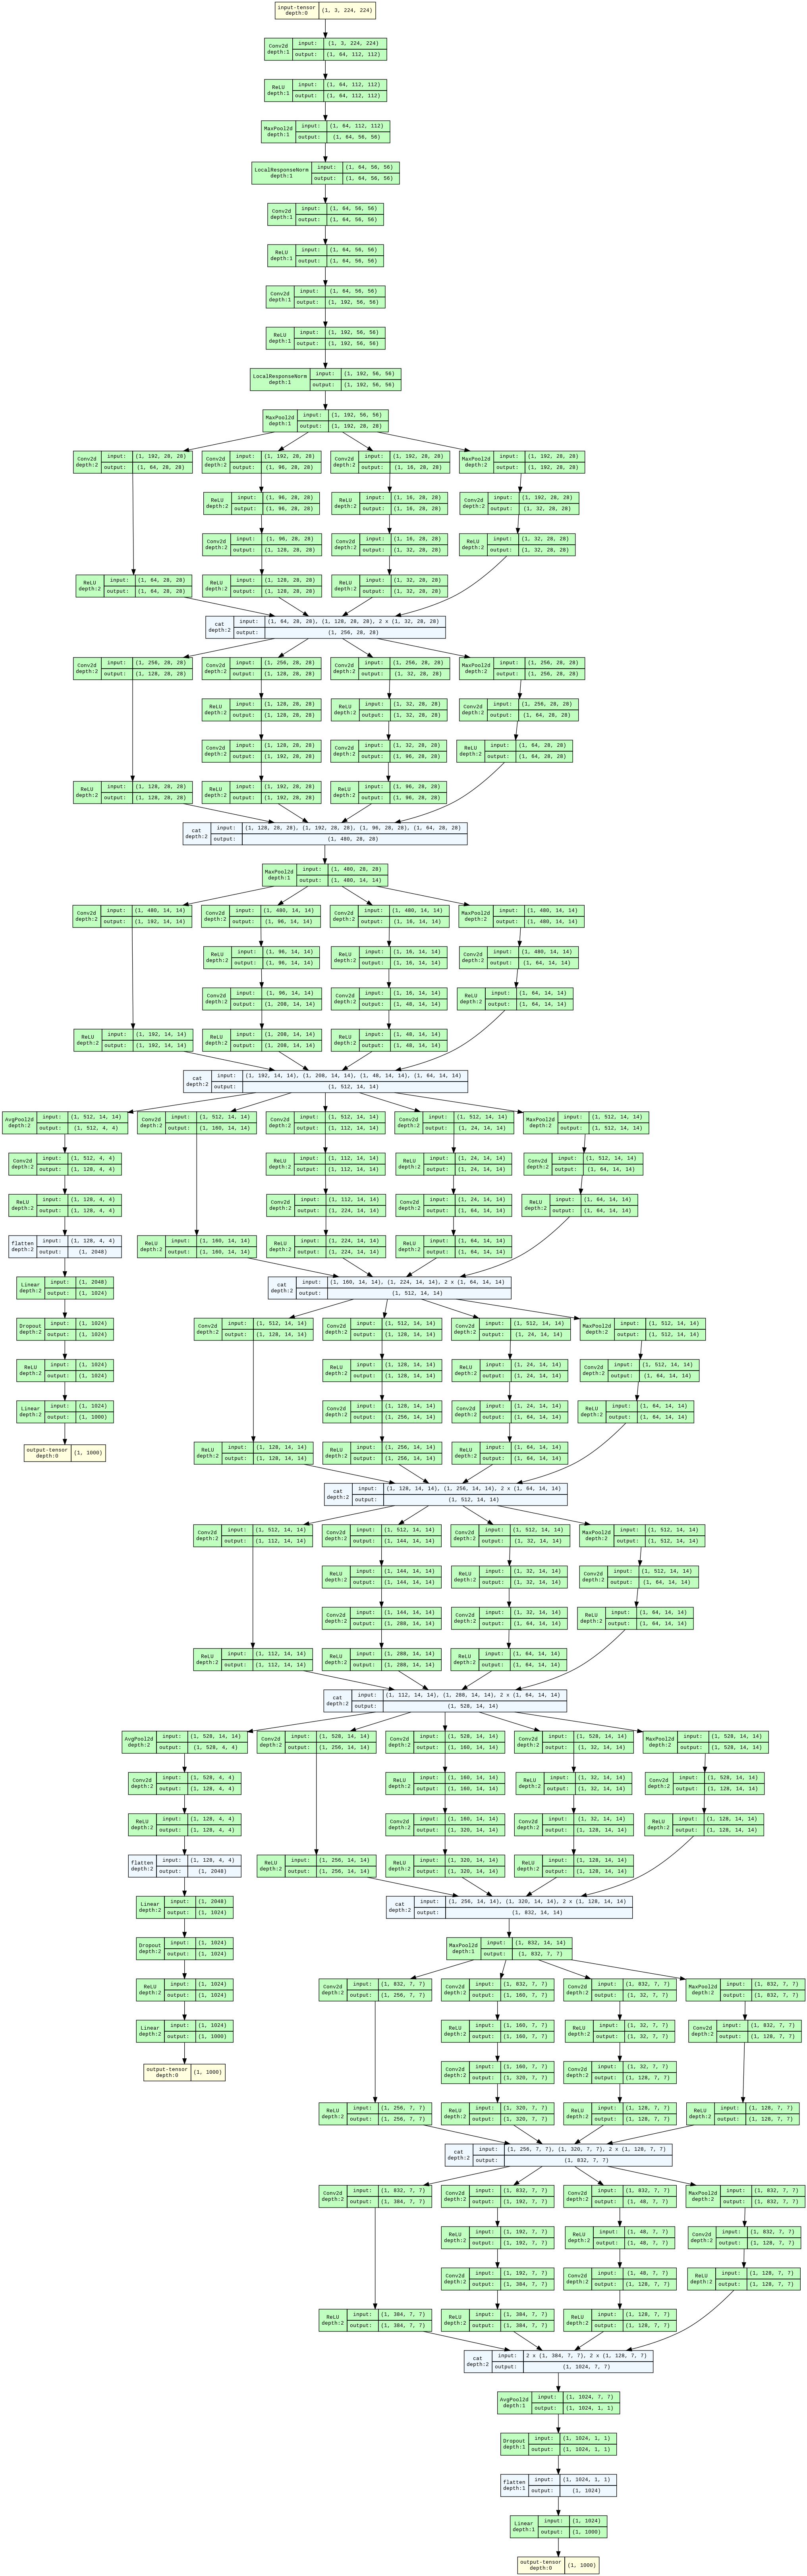

In [ ]:
model_graph1.visual_graph

In [ ]:
batch_size, lr, num_epochs = 16, 0.4, 8
train_iter, val_iter, test_iter = load_dataset(batch_size, resize=224)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(model, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu())

Training on cuda:0
Epoch 1, Train loss 6.94, Train accuracy 0.30, Validation loss 6.97, Validation accuracy 0.10
Epoch 2, Train loss 6.94, Train accuracy 0.25, Validation loss 6.97, Validation accuracy 0.13
Epoch 3, Train loss 6.94, Train accuracy 0.21, Validation loss 6.97, Validation accuracy 0.05
Epoch 4, Train loss 6.93, Train accuracy 0.25, Validation loss 6.97, Validation accuracy 0.10
Epoch 5, Train loss 6.94, Train accuracy 0.27, Validation loss 6.97, Validation accuracy 0.05
Epoch 6, Train loss 6.93, Train accuracy 0.24, Validation loss 6.97, Validation accuracy 0.10
Epoch 7, Train loss 6.94, Train accuracy 0.26, Validation loss 6.97, Validation accuracy 0.05
Epoch 8, Train loss 6.94, Train accuracy 0.28, Validation loss 6.98, Validation accuracy 0.10
Test loss 6.93, Test accuracy 0.11
